# Understanding Neural Networks

### Load Libraries

In [1]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

import os
from os import listdir
import mmap
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
import pprint as pp

import numpy as np
from sklearn.metrics import accuracy_score

import matplotlib
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

#### Check Environment

In [2]:
requirements = {
    torch: '1',
    matplotlib: '3'
}

def check_requirements(requirements):
    for requirement in requirements:
        error_message = '{} environment does not match requirement'.format(requirement.__name__)
        assert (requirement.__version__[0] == requirements[requirement]), error_message

check_requirements(requirements)

#### Check CUDA

In [3]:
cuda = torch.cuda.is_available()

if cuda:
    torch.backends.cudnn.benchmark = True
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

cuda

True

### Useful Functions

In [4]:
class PlotGrid:
    def __init__(self, figsize=None):
        self.fig = plt.figure(figsize=figsize)
        self.ax = {}
        self.xlim = {}
        self.ylim = {}
        self.filled = {}
        self.grid = {}
    
    def plot(self, position_id, data, title=None, xlim=None, ylim=None, filled=None, grid=None):
        if position_id in self.ax:
            ax = self.ax[position_id]
        else:
            ax = self.fig.add_subplot(position_id)

        # cache current values
        if title is None:
            title = ax.get_title()

        if xlim is not None:
            self.xlim[position_id] = xlim

        if ylim is not None:
            self.ylim[position_id] = ylim

        if filled is not None:
            self.filled[position_id] = filled
        
        if position_id not in self.filled:
            self.filled[position_id] = True

        if grid is not None:
            self.grid[position_id] = grid
        
        if position_id not in self.grid:
            self.grid[position_id] = True

        ax.clear()
        if type(data).__name__ == 'Image':
            ax.imshow(data)
        else:
            data = data.cpu().numpy()
            ax.plot(data)

            if self.filled[position_id]:
                ax.fill_between(range(len(data)), data)

            if self.grid[position_id]:
                ax.grid(True)

            # set xlim
            if position_id in self.xlim:
                ax.set_xlim(*self.xlim[position_id])

            # set ylim
            if position_id in self.ylim:
                ax.set_ylim(*self.ylim[position_id])
        
        # set title
        if title is not None:
            ax.set_title(title)
        
        self.fig.tight_layout()
        self.fig.show()
        self.fig.canvas.draw()
        self.ax[position_id] = ax


#### Test PlotGrid

<IPython.core.display.Javascript object>


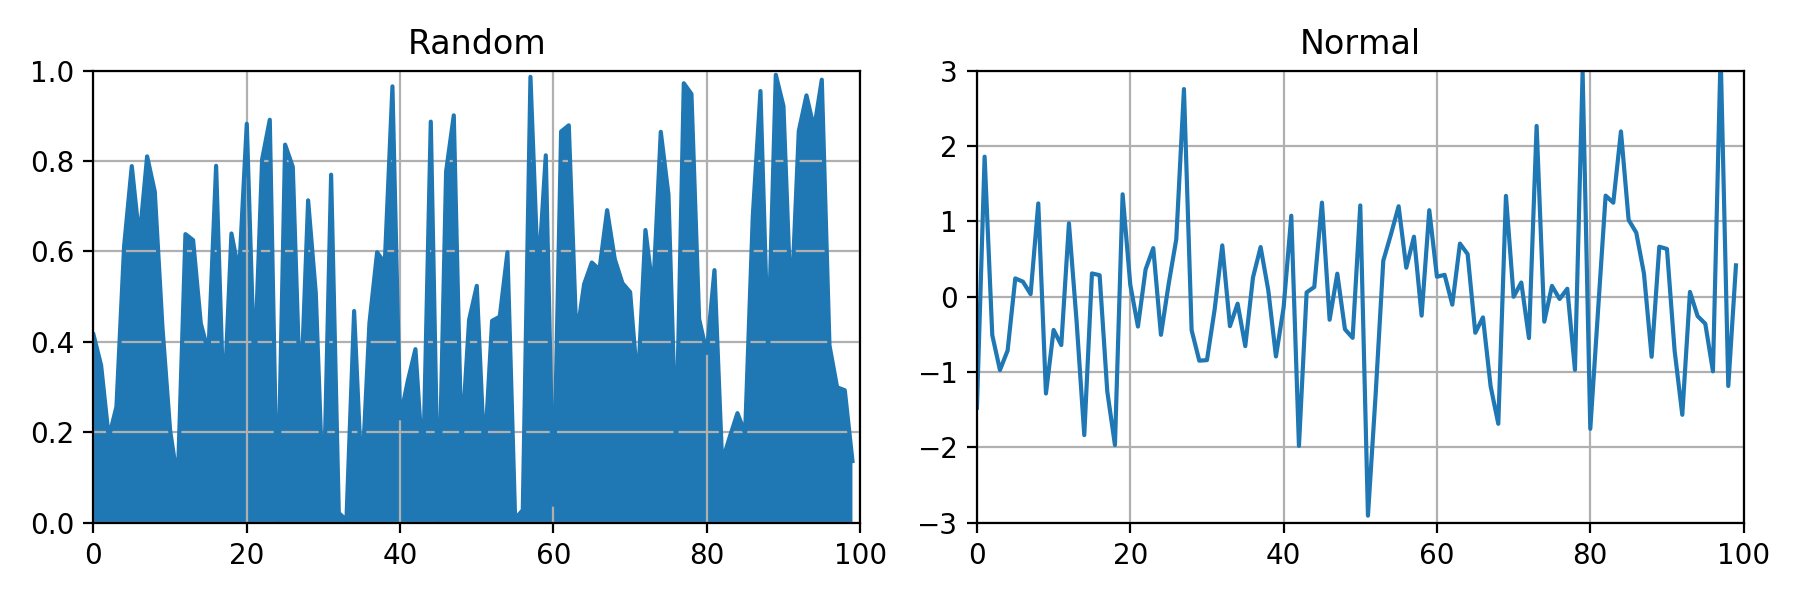

In [5]:
# test plotting function
plot_grid = PlotGrid(figsize=(9,3))

# initialize figures
# random
data = torch.rand((100))
plot_grid.plot(121, data, title='Random', xlim=(0, len(data)), ylim=(0.0, 1.0))
# normal
data = torch.randn((100))
plot_grid.plot(122, data, title='Normal', xlim=(0, len(data)), ylim=(-3.0, 3.0), filled=False)

In [6]:
# update plots

for i in range(10):
    # random
    data = torch.rand((100))
    plot_grid.plot(121, data)
    # normal
    data = torch.randn((100))
    plot_grid.plot(122, data)

In [7]:
def pathJoin(*args):
    return os.path.abspath(os.path.join(*args))

def pprint(*args):
    pp.pprint(*args)

#### Load Dataset - CIFAR10

In [8]:
cifar10_dataset_path = os.path.join('datasets', 'cifar10')

cifar10_transforms = transforms.Compose([
    transforms.ToTensor()
])

cifar10_train_dataset = datasets.CIFAR10(cifar10_dataset_path,
                                         train=True,
                                         download=True,
                                         transform=cifar10_transforms)

cifar10_test_dataset = datasets.CIFAR10(cifar10_dataset_path,
                                         train=False,
                                         download=True,
                                         transform=cifar10_transforms)

cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train_dataset,
                                                   batch_size=64,
                                                   shuffle=True,
                                                   num_workers=1)

cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_dataset,
                                                   batch_size=64,
                                                   shuffle=False,
                                                   num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


#### Load Dataset - ImageNet

In [9]:
class BaseDataset(Dataset):

    def __init__(self, directory, split='train', transforms=None):
        self.datapoints = defaultdict(list)
        self.split = split
        self.directory = pathJoin(directory, split)
        self.datapoints = self.loadDataset()
        self.transforms = transforms

    def __len__(self):
        return len(self.datapoints)

    def __getitem__(self, idx):
        datapoint = self.loadDatapoint(idx)
        return datapoint

    def loadDatapoint(self, idx):
        raise NotImplementedError('Function "loadDatapoint" is not implemented')

    def loadDataset(self, name):
        raise NotImplementedError('Function "loadDataset" is not implemented')


In [10]:
class ImageNetDataset(BaseDataset):

    def __init__(self, directory, split='train', transforms=None):
        super().__init__(directory, split, transforms)
        self.descriptions = self.loadDescriptions()
        self.classes = self.loadClasses()
        self.groundtruths = self.loadValidationGroundtruths() if split == 'val' else []

    def loadDatapoint(self, idx):
        filepath = self.datapoints[idx]
        image = Image.open(filepath).convert('RGB')
        if self.split == 'val':
            groundtruth = self.groundtruths[idx]
        elif self.split == 'train':
            groundtruth = self.classes.index(filepath.split('/').pop().split('_')[0])
        if self.transforms:
            image = self.transforms(image)
        return (filepath, image, groundtruth, self.descriptions[groundtruth])

    def loadDataset(self):
        datapoints = []

        dataset_file_list_filename = 'ilsvrc2012{}.txt'.format(self.split)
        dataset_file_list_path = os.path.join(self.directory, dataset_file_list_filename)

        with open(dataset_file_list_path, 'r') as dataset_file_list_file:
            for line in tqdm(dataset_file_list_file, total=sum(1 for line in open(dataset_file_list_path))):
                file_path = pathJoin(self.directory, self.sanitizeFilename(line))
                datapoints.append(file_path)
        
        return datapoints
    
    def sanitizeFilename(self, filename):
        return filename.replace('"', '').strip()

    def loadDescriptions(self):
        descriptions = []

        descriptions_filename = 'synsets_with_descriptions.txt'
        descriptions_path = pathJoin(self.directory, '..', descriptions_filename)

        with open(descriptions_path, 'r') as descriptions_file:
            for line in descriptions_file:
                description_breakdown = line.split(' ')
                description_breakdown.pop(0)
                description = ' '.join(description_breakdown).strip()
                descriptions.append(description)

        return descriptions

    def loadValidationGroundtruths(self):
        groundtruths = []

        groundtruths_filename = 'validation_ground_truth.txt'
        groundtruths_path = pathJoin(self.directory, '..', groundtruths_filename)

        with open(groundtruths_path, 'r') as groundtruths_file:
            for line in groundtruths_file:
                groundtruth_breakdown = line.split(' ')
                groundtruth_breakdown.pop(0)
                groundtruth = ' '.join(groundtruth_breakdown).strip()
                groundtruths.append(int(groundtruth))

        return groundtruths

    def loadClasses(self):
        classes = []

        classes_filename = 'synsets.txt'
        classes_path = pathJoin(self.directory, '..', classes_filename)

        with open(classes_path, 'r') as classes_file:
            for line in classes_file:
                classes.append(line.strip())

        return classes


In [11]:
BATCH_SIZE = 64

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
#     normalize
])

imagenet_dataset_path = os.path.join('datasets', 'imagenet')

imagenet_train_dataset = ImageNetDataset(imagenet_dataset_path, transforms=test_transforms)
imagenet_val_dataset = ImageNetDataset(imagenet_dataset_path, split='val', transforms=test_transforms)
imagenet_test_dataset = ImageNetDataset(imagenet_dataset_path, split='test')

imagenet_train_loader = DataLoader(imagenet_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
imagenet_val_loader = DataLoader(imagenet_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
imagenet_test_loader = DataLoader(imagenet_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 100000/100000 [00:01<00:00, 87228.59it/s]


#### View Image(s)

<IPython.core.display.Javascript object>


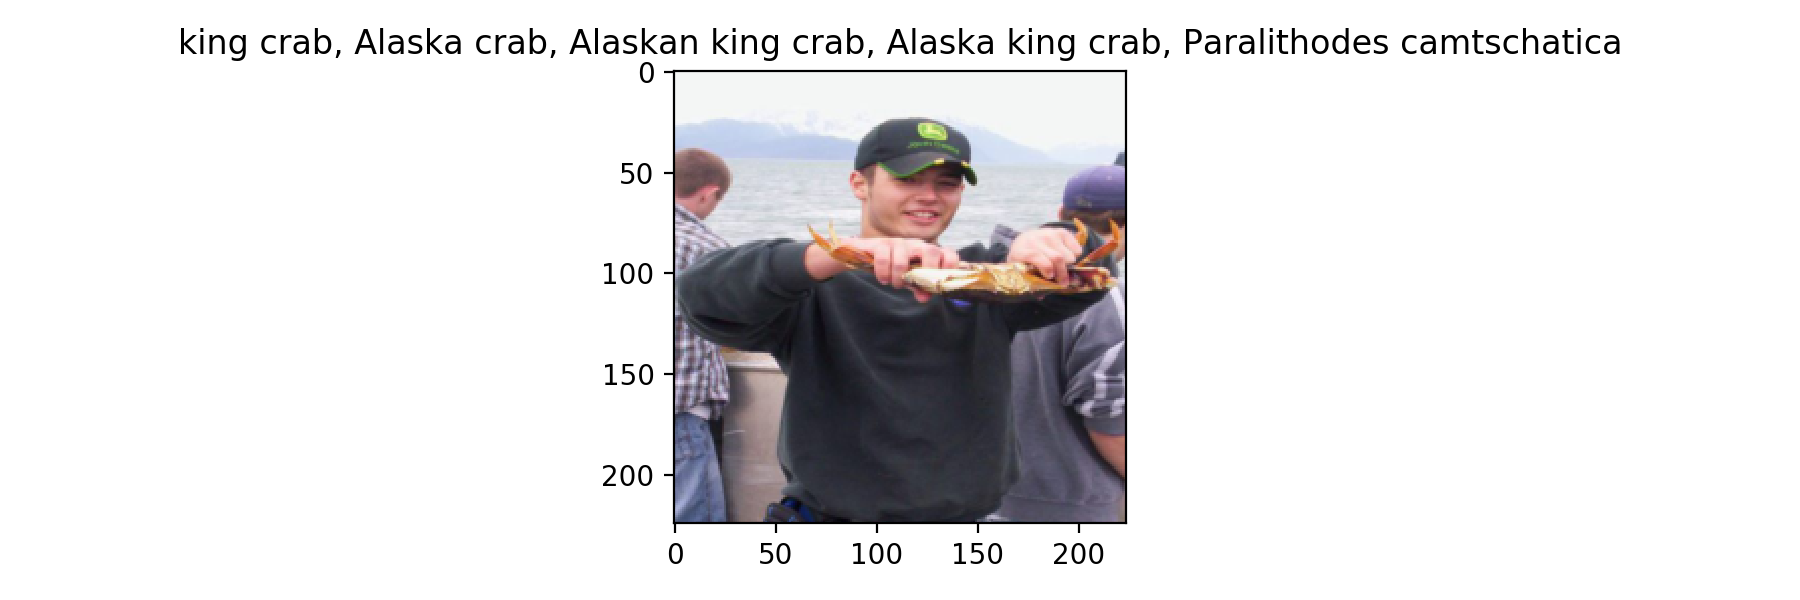

In [12]:
image_grid = PlotGrid(figsize=(9,3))

toImage = transforms.ToPILImage()

In [13]:
for index, image in enumerate(imagenet_train_dataset):
    img = image[1]
    image_grid.plot(111, toImage(img), title=image[3])
    if (index + 1) == 9:
        break

#### Load Model

In [14]:
resnet50 = models.resnet50(pretrained=True)

# resnet50

#### Check Validation Performance

<IPython.core.display.Javascript object>


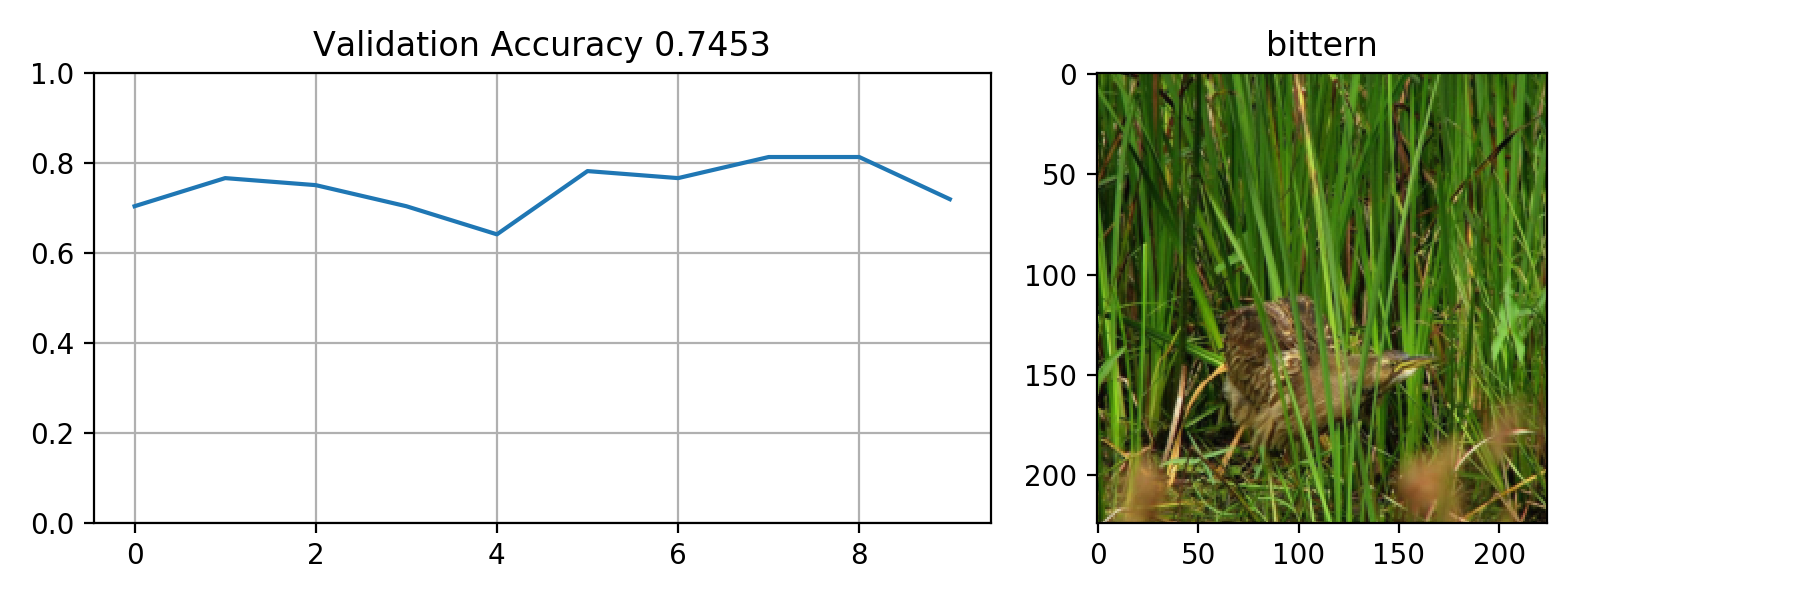

In [30]:
imagenet_validation_grid = PlotGrid(figsize=(9,3))

In [34]:
accuracy = []

imagenet_validation_grid.plot(121, torch.tensor(accuracy), title='Validation Accuracy', filled=False, ylim=(0,1))

for index, batch in enumerate(imagenet_val_loader):
    output = resnet50(batch[1].cuda())
    _, pred = output.topk(1, 1, True, True)
    # predicted_descriptions = [ imagenet_val_dataset.descriptions[x] for x in pred.squeeze() ]
    # pprint(list(zip(batch[3], predicted_descriptions)))
    # pprint(list(zip(batch[2], pred.squeeze())))
    batch_accuracy = accuracy_score(batch[2], pred.cpu().squeeze())
    accuracy.append(batch_accuracy)
    imagenet_validation_grid.plot(121, torch.tensor(accuracy), title='Validation Accuracy {0:.4f}'.format(np.mean(accuracy)))
    imagenet_validation_grid.plot(122, toImage(batch[1][0]), title=batch[3][0])
    if (index + 1) % 10 == 0:
        break